In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


sensor_names = ['Acc_x', 'Acc_y', 'Acc_z', 'Gyr_x', 'Gyr_y', 'Gyr_z']
label_names = ["Resting", "Walking", "Running", "Driving"]
# Last row of training data for train/test split
train_end_index = 3511

In [179]:
def calculate_jerk(x,y,z):
    jerk_x = np.diff(x, axis=1)
    jerk_y = np.diff(y, axis=1)
    jerk_z = np.diff(z, axis=1)

    jerk_x = np.hstack((np.zeros((jerk_x.shape[0], 1)), jerk_x))
    jerk_y = np.hstack((np.zeros((jerk_y.shape[0], 1)), jerk_y))
    jerk_z = np.hstack((np.zeros((jerk_z.shape[0], 1)), jerk_z))

    return np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)

In [180]:
# load in the given "real" data
# this loading of generated and real data are done seperately to ensure that distrubtions between train and test sets are even.

labels = np.loadtxt('labels_train_1.csv', dtype='int')
data_slice_0 = np.loadtxt(sensor_names[0] + '_train_1.csv',
                            delimiter=',')
data = np.empty((data_slice_0.shape[0], data_slice_0.shape[1],
                    len(sensor_names)))
data[:, :, 0] = data_slice_0
del data_slice_0
for sensor_index in range(1, len(sensor_names)):
    data[:, :, sensor_index] = np.loadtxt(
        sensor_names[sensor_index] + '_train_1.csv', delimiter=',')
    

acc_data = data[:,:, 0:3]
gyr_data = data[:,:, 3:6]

total_acc = np.linalg.norm(acc_data, axis=-1)
total_gyr = np.linalg.norm(gyr_data, axis=-1)

acc_jerk_magnitude = calculate_jerk(acc_data[:, :, 0], acc_data[:, :, 1], acc_data[:, :, 2])
#gyr_jerk_magnitude = calculate_jerk(gyr_data[:, :, 0], gyr_data[:, :, 1], gyr_data[:, :, 2])



total_data = np.stack((total_acc, total_gyr, acc_jerk_magnitude), axis=-1)

given_train_data = total_data[:train_end_index+1, :, :]
given_train_labels = labels[:train_end_index+1]
given_test_data = total_data[train_end_index+1:, :, :]
given_test_labels = labels[train_end_index+1:]

In [181]:
# load in generated data

# gen_labels = np.loadtxt('generated_labels_train_1.csv', dtype='int')
# data_slice_0 = np.loadtxt('generated_' + sensor_names[0] + '_train_1.csv',
#                             delimiter=',')
# data = np.empty((data_slice_0.shape[0], data_slice_0.shape[1],
#                     len(sensor_names)))
# data[:, :, 0] = data_slice_0
# del data_slice_0
# for sensor_index in range(1, len(sensor_names)):
#     data[:, :, sensor_index] = np.loadtxt(
#         'generated_' + sensor_names[sensor_index] + '_train_1.csv', delimiter=',')
    

# acc_data = data[:,:, 0:3]
# gyr_data = data[:,:, 3:6]

# total_acc = np.linalg.norm(acc_data, axis=-1)
# total_gyr = np.linalg.norm(gyr_data, axis=-1)

# x = acc_data[:, :, 0]
# y = acc_data[:, :, 1]
# z = acc_data[:, :, 2]


# jerk_x = np.diff(x, axis=1)
# jerk_y = np.diff(y, axis=1)
# jerk_z = np.diff(z, axis=1)

# jerk_x = np.hstack((np.zeros((jerk_x.shape[0], 1)), jerk_x))
# jerk_y = np.hstack((np.zeros((jerk_y.shape[0], 1)), jerk_y))
# jerk_z = np.hstack((np.zeros((jerk_z.shape[0], 1)), jerk_z))

# jerk_magnitude = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)



# total_data = np.stack((total_acc, total_gyr, jerk_magnitude), axis=-1)

# gen_train_data = total_data[:train_end_index+1, :, :]
# gen_train_labels = gen_labels[:train_end_index+1]
# gen_test_data = total_data[train_end_index+1:, :, :]
# gen_test_labels = gen_labels[train_end_index+1:]

In [182]:
# now combine given and generated sets

# train_data = np.concatenate((given_train_data, gen_train_data), axis=0)
# train_labels = np.concatenate((given_train_labels, gen_train_labels), axis=0)
# test_data = np.concatenate((given_test_data, gen_test_data), axis=0)
# test_labels = np.concatenate((given_test_labels, gen_test_labels), axis=0)

train_data = given_train_data
train_labels = given_train_labels
test_data = given_test_data
test_labels = given_test_labels


In [184]:
class CNN_RNN_Model(nn.Module):
    def __init__(self, num_classes=4, input_channels=6, feature_length=60, rnn_hidden_size=128, num_rnn_layers=4):
        super(CNN_RNN_Model, self).__init__()
        
        # CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),  # Activation
            nn.MaxPool1d(kernel_size=2, stride=2),  # Downsampling
            nn.Dropout(p=0.5),

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # Another Conv layer
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Another Conv layer
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),

        )
        
        # Compute the output size after CNN layers
        cnn_output_size = 448 #32 * (feature_length // 4)  # Adjust this if CNN structure changes

        # RNN for temporal dependency learning
        self.rnn = nn.LSTM(input_size=cnn_output_size, 
                           hidden_size=rnn_hidden_size, 
                           num_layers=num_rnn_layers, 
                           batch_first=True, dropout=0.3)

        # Fully connected layer for classification
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, seq_length, input_channels, feature_length)
        batch_size, seq_length, channels, feature_length = x.size()

        # Merge batch and sequence dimensions for CNN processing
        x = x.view(-1, channels, feature_length)  # Shape: (batch_size * seq_length, channels, feature_length)
        
        # Pass through CNN
        x = self.cnn(x)  # Shape: (batch_size * seq_length, 32, feature_length // 4)
        x = x.view(batch_size, seq_length, -1)  # Reshape back: (batch_size, seq_length, cnn_output_size)

        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # Shape: (batch_size, seq_length, rnn_hidden_size)

        # Use the final output of the RNN for classification
        final_output = rnn_out[:, -1, :]  # Shape: (batch_size, rnn_hidden_size)

        # Pass through the fully connected layer
        out = self.fc(final_output)  # Shape: (batch_size, num_classes)

        return out

model = CNN_RNN_Model(num_classes=4, input_channels=3, feature_length=60)
print(model)


CNN_RNN_Model(
  (cnn): Sequential(
    (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): ReLU()
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (rnn): LSTM(448, 128, num_layers=4, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [185]:
# create sequences of examples to learn the temporal relationship between them.

def create_data_sequences(features, labels, seq_length):
    # Generate sequences and corresponding labels
    sequences = []
    sequence_labels = []

    # pad the first few sequences with zero vectors
    empty_vectors = np.zeros((seq_length-1, features.shape[1], features.shape[2]))
    features = np.vstack((empty_vectors, features))


    for i in range(len(features)-seq_length+1):
        sequence = features[i:i + seq_length] 
        sequences.append(sequence.transpose(0, 2, 1))
        
        # Use the label of the last example in the sequence as the sequence label
        sequence_labels.append(labels[i])

    sequences = torch.tensor(sequences, dtype=torch.float32)
    sequence_labels = torch.tensor(sequence_labels, dtype=torch.long)


    return sequences, sequence_labels

In [194]:
#one_hot_sequence_labels = F.one_hot(sequence_labels-1, num_classes=4).float()

# training dataset
sequences, sequence_labels = create_data_sequences(train_data, train_labels, seq_length=5)

# test dataset
test_sequences, test_sequence_labels = create_data_sequences(test_data, test_labels, seq_length=5)
test_sequence_labels.to(device)
test_sequences.to(device)

dataset = TensorDataset(sequences, sequence_labels-1)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = CNN_RNN_Model(num_classes=4, input_channels=3, feature_length=60).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [187]:
def compute_accuracy(outputs, targets):
    predicted_classes = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(targets, predicted_classes.cpu())
    return accuracy

Epoch [1/300], Train Accuracy: 0.3806, Test Accuracy: 0.4073
Epoch [2/300], Train Accuracy: 0.6245, Test Accuracy: 0.5603
Epoch [3/300], Train Accuracy: 0.7255, Test Accuracy: 0.7875
Epoch [4/300], Train Accuracy: 0.7782, Test Accuracy: 0.7134
Epoch [5/300], Train Accuracy: 0.8355, Test Accuracy: 0.7192
Epoch [6/300], Train Accuracy: 0.8639, Test Accuracy: 0.6986
Epoch [7/300], Train Accuracy: 0.8938, Test Accuracy: 0.7422
Epoch [8/300], Train Accuracy: 0.8890, Test Accuracy: 0.7716
Epoch [9/300], Train Accuracy: 0.8961, Test Accuracy: 0.7422
Epoch [10/300], Train Accuracy: 0.9238, Test Accuracy: 0.7675
Epoch [11/300], Train Accuracy: 0.9273, Test Accuracy: 0.7616
Epoch [12/300], Train Accuracy: 0.9221, Test Accuracy: 0.7911
Epoch [13/300], Train Accuracy: 0.9330, Test Accuracy: 0.8181
Epoch [14/300], Train Accuracy: 0.9334, Test Accuracy: 0.7446
Epoch [15/300], Train Accuracy: 0.9388, Test Accuracy: 0.8452
Epoch [16/300], Train Accuracy: 0.9481, Test Accuracy: 0.8835
Epoch [17/300], T

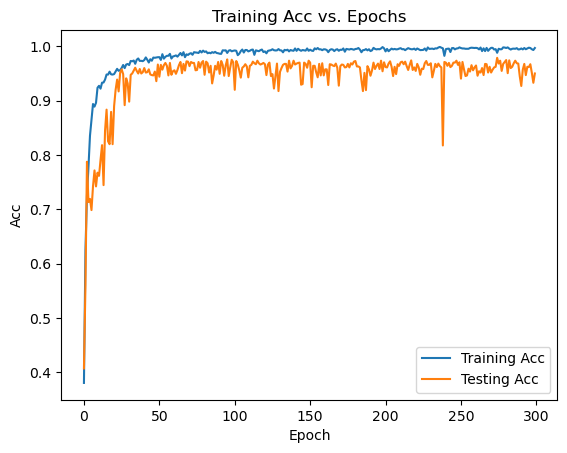

In [ ]:
# Training loop
EPOCHS = 50

train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for batch_sequences, batch_labels in dataloader:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        
        outputs = model(batch_sequences)
        predicted_classes = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, batch_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        running_acc += compute_accuracy(outputs, batch_labels.cpu())

    avg_acc = running_acc/len(dataloader)
    train_acc.append(avg_acc)

    model.eval() 
    with torch.no_grad():        
        test_outputs = model(test_sequences.to(device))
        avg_test_acc = compute_accuracy(test_outputs, test_sequence_labels - 1)
        test_acc.append(avg_test_acc)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Accuracy: {avg_acc:.4f}, Test Accuracy: {avg_test_acc:.4f}")


plt.plot(train_acc, label='Training Acc')
plt.plot(test_acc, label='Testing Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Training Acc vs. Epochs')
plt.legend()
plt.show()

In [189]:
# generated predicted classes for the test set

test_sequences, test_sequence_labels = create_data_sequences(test_data, test_labels, seq_length=5)

model.eval()
with torch.no_grad():
    test_sequences = test_sequences.to(device)
    
    test_outputs = model(test_sequences)

    predicted_classes = torch.argmax(test_outputs, dim=1)

In [190]:
#test_labels_pt = torch.tensor(test_labels - 1, dtype=torch.long)

# Compute micro and macro-averaged F1 scores
accuracy = accuracy_score(test_sequence_labels-1, predicted_classes.cpu())
micro_f1 = f1_score(test_sequence_labels-1, predicted_classes.cpu(), average='micro')
macro_f1 = f1_score(test_sequence_labels-1, predicted_classes.cpu(), average='macro')
print(f'Accuracy: {accuracy}')
print(f'Micro-averaged F1 score: {micro_f1}')
print(f'Macro-averaged F1 score: {macro_f1}')

Accuracy: 0.949970570924073
Micro-averaged F1 score: 0.949970570924073
Macro-averaged F1 score: 0.9334469472376895


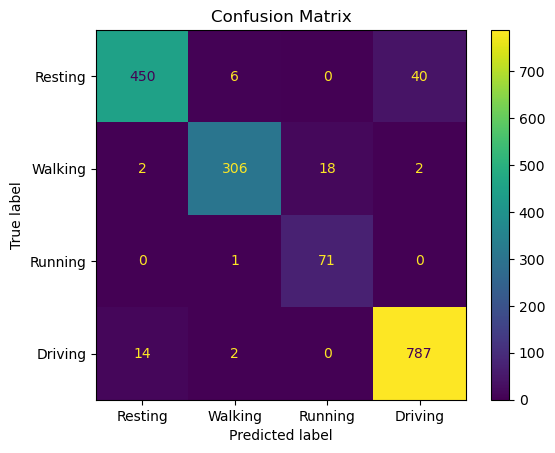

In [191]:
cm = confusion_matrix(test_sequence_labels-1, predicted_classes.cpu(), labels=range(4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [193]:
torch.save(model.state_dict(), "combined_model.pth")